#GEDI L1B data processing by using coordinates
Author: Savannah Cooley

Version modified by Tassio Koiti Igawa

Repository - Original code: https://github.com/savcooley/full_waveform_lidar_training.git

In [1]:
# Install

# Install the necessary Python libraries using pip.
!pip install earthaccess h5py geopandas matplotlib seaborn requests shapely folium
!pip install --upgrade earthaccess

# Import libraries
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import folium
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
import earthaccess


print("All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.1.0 which is incompatible.
All libraries imported successfully!


In [ ]:
# Mount Your Google Drive
# Mounting your Google Drive allows the notebook to save output files and access data you may have stored. You will be prompted to authorize Colab to access your drive.
from google.colab import drive
drive.mount('/content/drive')

##Instructions

- Insert the area of interest and the start and end dates of the data collection into the code.

- Provide the necessary information to log in to Earthdata.

Enter your Earthdata Login username: tassioigawa
Enter your Earthdata password: ··········
✓ Successfully authenticated with NASA Earthdata!
Area of Interest (Bounding Box): [-53.29222822843251, -3.740016664673107, -52.65643629181753, -3.1698933787883066]
Longitude range: -53.29222822843251 to -52.65643629181753
Latitude range: -3.740016664673107 to -3.1698933787883066
 Using default AOI - will prioritize 5th granule for demo efficiency
Temporal range: 2024-06-01 to 2025-10-22
Processing Full Power beams only: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

🔍 Searching for GEDI L1B granules...
Searching for GEDI L1B data...
  Bounding box: [-53.29222822843251, -3.740016664673107, -52.65643629181753, -3.1698933787883066]
  Date range: 2024-06-01 to 2025-10-22
  Max results: 2000
Found 24 GEDI L1B granules

📋 Found granules:
  1. GEDI01_B_2024163195755_O31141_04_T07120_02_006_02_V002
  2. GEDI01_B_2024176033257_O31332_01_T06470_02_006_03_V002 (← DEMO PRIORITY)
  ... and 22 more granule

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024163195755_O31141_04_T07120_02_006_02_V002.h5 (2.70 GB)

Opening GEDI file: GEDI01_B_2024163195755_O31141_04_T07120_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168407
    Shots in AOI: 771
    ✓ Extracted 771 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 167852
    Shots in AOI: 748
    ✓ Extracted 748 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 168031
    Shots in AOI: 706
    ✓ Extracted 706 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 168175
    Shots in AOI: 688
    ✓ Extracted 688 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 771 → 771 shots (100.0% retained)
  BEAM0110: 748 → 748 shots (100.0% retained)
  B

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024176033257_O31332_01_T06470_02_006_03_V002.h5 (2.07 GB)

Opening GEDI file: GEDI01_B_2024176033257_O31332_01_T06470_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 95701
    Shots in AOI: 80
    ✓ Extracted 80 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 105344
    Shots in AOI: 103
    ✓ Extracted 103 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 96676
    Shots in AOI: 122
    ✓ Extracted 122 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 95401
    Shots in AOI: 147
    ✓ Extracted 147 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 80 → 80 shots (100.0% retained)
  BEAM0110: 103 → 103 shots (100.0% retained)
  BEAM1000

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024180015712_O31393_01_T09622_02_006_03_V002.h5 (2.11 GB)

Opening GEDI file: GEDI01_B_2024180015712_O31393_01_T09622_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 98075
    Shots in AOI: 1341
    ✓ Extracted 1341 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107678
    Shots in AOI: 1343
    ✓ Extracted 1343 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 99065
    Shots in AOI: 1340
    ✓ Extracted 1340 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97763
    Shots in AOI: 1345
    ✓ Extracted 1345 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1341 → 1248 shots (93.1% retained)
  BEAM0110: 1343 → 1291 shots (96.1% retain

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024206031011_O31797_04_T04733_02_006_03_V002.h5 (2.62 GB)

Opening GEDI file: GEDI01_B_2024206031011_O31797_04_T04733_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168389
    Shots in AOI: 942
    ✓ Extracted 942 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 167992
    Shots in AOI: 961
    ✓ Extracted 961 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 167946
    Shots in AOI: 985
    ✓ Extracted 985 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 167983
    Shots in AOI: 1014
    ✓ Extracted 1014 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 942 → 926 shots (98.3% retained)
  BEAM0110: 961 → 947 shots (98.5% retained)
  B

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024210135503_O31866_01_T00778_02_006_03_V002.h5 (2.09 GB)

Opening GEDI file: GEDI01_B_2024210135503_O31866_01_T00778_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 95678
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM0101

  Processing BEAM0110...
    Total shots in beam: 105249
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM0110

  Processing BEAM1000...
    Total shots in beam: 96946
    Shots in AOI: 3
    ✓ Extracted 3 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 95401
    Shots in AOI: 27
    ✓ Extracted 27 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM1000: 3 → 0 shots (0.0% retained)
  BEAM1011: 27 → 0 shots (0.0% retained)

Overall: 30 → 0 shots (0

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024214121739_O31927_01_T08505_02_006_03_V002.h5 (2.59 GB)

Opening GEDI file: GEDI01_B_2024214121739_O31927_01_T08505_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 118334
    Shots in AOI: 233
    ✓ Extracted 233 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 127941
    Shots in AOI: 207
    ✓ Extracted 207 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 119280
    Shots in AOI: 185
    ✓ Extracted 185 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 117999
    Shots in AOI: 159
    ✓ Extracted 159 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 233 → 212 shots (91.0% retained)
  BEAM0110: 207 → 204 shots (98.6% retained)
  BEA

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024232164042_O32209_04_T05850_02_006_03_V002.h5 (2.68 GB)

Opening GEDI file: GEDI01_B_2024232164042_O32209_04_T05850_02_006_03_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168328
    Shots in AOI: 1175
    ✓ Extracted 1175 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 167941
    Shots in AOI: 1152
    ✓ Extracted 1152 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 167899
    Shots in AOI: 1118
    ✓ Extracted 1118 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 168067
    Shots in AOI: 1104
    ✓ Extracted 1104 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1175 → 0 shots (0.0% retained)
  BEAM0110: 1152 → 0 shots (0.0% retained)
 

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024245001500_O32400_01_T06776_02_006_04_V002.h5 (2.04 GB)

Opening GEDI file: GEDI01_B_2024245001500_O32400_01_T06776_02_006_04_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97965
    Shots in AOI: 1347
    ✓ Extracted 1347 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107548
    Shots in AOI: 1338
    ✓ Extracted 1338 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 98997
    Shots in AOI: 1343
    ✓ Extracted 1343 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97618
    Shots in AOI: 1341
    ✓ Extracted 1341 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1347 → 0 shots (0.0% retained)
  BEAM0110: 1338 → 0 shots (0.0% retained)
  BE

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024248224056_O32461_01_T05506_02_006_04_V002.h5 (2.08 GB)

Opening GEDI file: GEDI01_B_2024248224056_O32461_01_T05506_02_006_04_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97831
    Shots in AOI: 1187
    ✓ Extracted 1187 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107445
    Shots in AOI: 1166
    ✓ Extracted 1166 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 99111
    Shots in AOI: 1144
    ✓ Extracted 1144 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97636
    Shots in AOI: 1119
    ✓ Extracted 1119 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1187 → 1187 shots (100.0% retained)
  BEAM0110: 1166 → 1165 shots (99.9% retai

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024252210835_O32522_01_T05353_02_006_02_V002.h5 (2.05 GB)

Opening GEDI file: GEDI01_B_2024252210835_O32522_01_T05353_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97398
    Shots in AOI: 1338
    ✓ Extracted 1338 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107129
    Shots in AOI: 1340
    ✓ Extracted 1340 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 98344
    Shots in AOI: 1341
    ✓ Extracted 1341 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97145
    Shots in AOI: 1338
    ✓ Extracted 1338 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1338 → 1331 shots (99.5% retained)
  BEAM0110: 1340 → 1329 shots (99.2% retain

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024256193600_O32583_01_T08046_02_006_02_V002.h5 (2.06 GB)

Opening GEDI file: GEDI01_B_2024256193600_O32583_01_T08046_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 95924
    Shots in AOI: 665
    ✓ Extracted 665 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 105724
    Shots in AOI: 687
    ✓ Extracted 687 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 97071
    Shots in AOI: 712
    ✓ Extracted 712 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 95791
    Shots in AOI: 745
    ✓ Extracted 745 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 665 → 523 shots (78.6% retained)
  BEAM0110: 687 → 509 shots (74.1% retained)
  BEAM10

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024260180233_O32644_01_T00931_02_006_02_V002.h5 (2.04 GB)

Opening GEDI file: GEDI01_B_2024260180233_O32644_01_T00931_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 96060
    Shots in AOI: 783
    ✓ Extracted 783 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 105736
    Shots in AOI: 804
    ✓ Extracted 804 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 97166
    Shots in AOI: 826
    ✓ Extracted 826 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 95774
    Shots in AOI: 852
    ✓ Extracted 852 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 783 → 732 shots (93.5% retained)
  BEAM0110: 804 → 744 shots (92.5% retained)
  BEAM10

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024264162831_O32705_01_T08199_02_006_02_V002.h5 (2.09 GB)

Opening GEDI file: GEDI01_B_2024264162831_O32705_01_T08199_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97395
    Shots in AOI: 1342
    ✓ Extracted 1342 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 106894
    Shots in AOI: 1329
    ✓ Extracted 1329 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 98370
    Shots in AOI: 1341
    ✓ Extracted 1341 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97071
    Shots in AOI: 1340
    ✓ Extracted 1340 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1342 → 0 shots (0.0% retained)
  BEAM0110: 1329 → 0 shots (0.0% retained)
  BE

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024268145349_O32766_01_T11198_02_006_02_V002.h5 (2.08 GB)

Opening GEDI file: GEDI01_B_2024268145349_O32766_01_T11198_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97843
    Shots in AOI: 1284
    ✓ Extracted 1284 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107662
    Shots in AOI: 1248
    ✓ Extracted 1248 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 98817
    Shots in AOI: 1228
    ✓ Extracted 1228 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97599
    Shots in AOI: 1207
    ✓ Extracted 1207 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1284 → 0 shots (0.0% retained)
  BEAM0110: 1248 → 0 shots (0.0% retained)
  BE

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024294160731_O33170_04_T08849_02_006_02_V002.h5 (1.29 GB)

Opening GEDI file: GEDI01_B_2024294160731_O33170_04_T08849_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 50871
    Shots in AOI: 1217
    ✓ Extracted 1217 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 51913
    Shots in AOI: 1242
    ✓ Extracted 1242 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 51961
    Shots in AOI: 1265
    ✓ Extracted 1265 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 50882
    Shots in AOI: 1293
    ✓ Extracted 1293 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1217 → 0 shots (0.0% retained)
  BEAM0110: 1242 → 0 shots (0.0% retained)
  BEA

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024313210045_O33468_01_T09316_02_006_02_V002.h5 (2.01 GB)

Opening GEDI file: GEDI01_B_2024313210045_O33468_01_T09316_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 96388
    Shots in AOI: 283
    ✓ Extracted 283 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 106089
    Shots in AOI: 255
    ✓ Extracted 255 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 97736
    Shots in AOI: 235
    ✓ Extracted 235 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 96199
    Shots in AOI: 206
    ✓ Extracted 206 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 283 → 260 shots (91.9% retained)
  BEAM0110: 255 → 247 shots (96.9% retained)
  BEAM10

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024332011751_O33750_04_T03310_02_006_02_V002.h5 (1.33 GB)

Opening GEDI file: GEDI01_B_2024332011751_O33750_04_T03310_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 50725
    Shots in AOI: 489
    ✓ Extracted 489 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 51772
    Shots in AOI: 502
    ✓ Extracted 502 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 51865
    Shots in AOI: 542
    ✓ Extracted 542 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 50778
    Shots in AOI: 559
    ✓ Extracted 559 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 489 → 489 shots (100.0% retained)
  BEAM0110: 502 → 502 shots (100.0% retained)
  BEAM1

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024340102637_O33880_01_T02660_02_006_02_V002.h5 (2.06 GB)

Opening GEDI file: GEDI01_B_2024340102637_O33880_01_T02660_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 98488
    Shots in AOI: 1333
    ✓ Extracted 1333 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 108162
    Shots in AOI: 1312
    ✓ Extracted 1312 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 99588
    Shots in AOI: 1282
    ✓ Extracted 1282 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 98209
    Shots in AOI: 1267
    ✓ Extracted 1267 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1333 → 9 shots (0.7% retained)
  BEAM0110: 1312 → 15 shots (1.1% retained)
  B

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024350175707_O34040_04_T04274_02_006_02_V002.h5 (2.66 GB)

Opening GEDI file: GEDI01_B_2024350175707_O34040_04_T04274_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168291
    Shots in AOI: 39
    ✓ Extracted 39 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 168164
    Shots in AOI: 17
    ✓ Extracted 17 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 167927
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM1000

  Processing BEAM1011...
    Total shots in beam: 168131
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 39 → 0 shots (0.0% retained)
  BEAM0110: 17 → 0 shots (0.0% retained)

Overall: 56 → 0 sh

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2024359030208_O34170_01_T09775_02_006_02_V002.h5 (2.62 GB)

Opening GEDI file: GEDI01_B_2024359030208_O34170_01_T09775_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 118483
    Shots in AOI: 647
    ✓ Extracted 647 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 128022
    Shots in AOI: 616
    ✓ Extracted 616 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 119640
    Shots in AOI: 590
    ✓ Extracted 590 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 118187
    Shots in AOI: 569
    ✓ Extracted 569 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 647 → 160 shots (24.7% retained)
  BEAM0110: 616 → 173 shots (28.1% retained)
  BEA

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2025003103255_O34330_04_T09966_02_006_02_V002.h5 (2.62 GB)

Opening GEDI file: GEDI01_B_2025003103255_O34330_04_T09966_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168216
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM0101

  Processing BEAM0110...
    Total shots in beam: 167904
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM0110

  Processing BEAM1000...
    Total shots in beam: 167903
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM1000

  Processing BEAM1011...
    Total shots in beam: 167858
    Shots in AOI: 0
    ✗ No shots found in AOI for BEAM1011
🗑️ Deleted file: GEDI01_B_2025003103255_O34330_04_T09966_02_006_02_V002.h5

PROCESSANDO GRANULE 22/24: GEDI01_B_2025026013052_O34681_04_T02040_02_006_02_V002


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2025026013052_O34681_04_T02040_02_006_02_V002.h5 (2.66 GB)

Opening GEDI file: GEDI01_B_2025026013052_O34681_04_T02040_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168206
    Shots in AOI: 294
    ✓ Extracted 294 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 168139
    Shots in AOI: 309
    ✓ Extracted 309 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 168087
    Shots in AOI: 347
    ✓ Extracted 347 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 168252
    Shots in AOI: 368
    ✓ Extracted 368 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 294 → 9 shots (3.1% retained)
  BEAM0110: 309 → 4 shots (1.3% retained)
  BEAM1000:

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2025030121419_O34750_01_T01084_02_006_02_V002.h5 (2.04 GB)

Opening GEDI file: GEDI01_B_2025030121419_O34750_01_T01084_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 97824
    Shots in AOI: 1346
    ✓ Extracted 1346 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 107595
    Shots in AOI: 1345
    ✓ Extracted 1345 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 98945
    Shots in AOI: 1346
    ✓ Extracted 1346 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 97715
    Shots in AOI: 1346
    ✓ Extracted 1346 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1346 → 96 shots (7.1% retained)
  BEAM0110: 1345 → 56 shots (4.2% retained)
  

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

✓ Baixado: GEDI01_B_2025048163509_O35032_04_T01734_02_006_02_V002.h5 (2.70 GB)

Opening GEDI file: GEDI01_B_2025048163509_O35032_04_T01734_02_006_02_V002.h5
Available beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Full Power beams found: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

  Processing BEAM0101...
    Total shots in beam: 168463
    Shots in AOI: 1349
    ✓ Extracted 1349 shots from BEAM0101

  Processing BEAM0110...
    Total shots in beam: 168239
    Shots in AOI: 1338
    ✓ Extracted 1338 shots from BEAM0110

  Processing BEAM1000...
    Total shots in beam: 168037
    Shots in AOI: 1341
    ✓ Extracted 1341 shots from BEAM1000

  Processing BEAM1011...
    Total shots in beam: 168151
    Shots in AOI: 1349
    ✓ Extracted 1349 shots from BEAM1011

Applying quality filters...
  Criteria: degrade_flag = 0, stale_return_flag = 0
  BEAM0101: 1349 → 0 shots (0.0% retained)
  BEAM0110: 1338 → 0 shots (0.0% retained)
 

<Figure size 1600x1000 with 0 Axes>

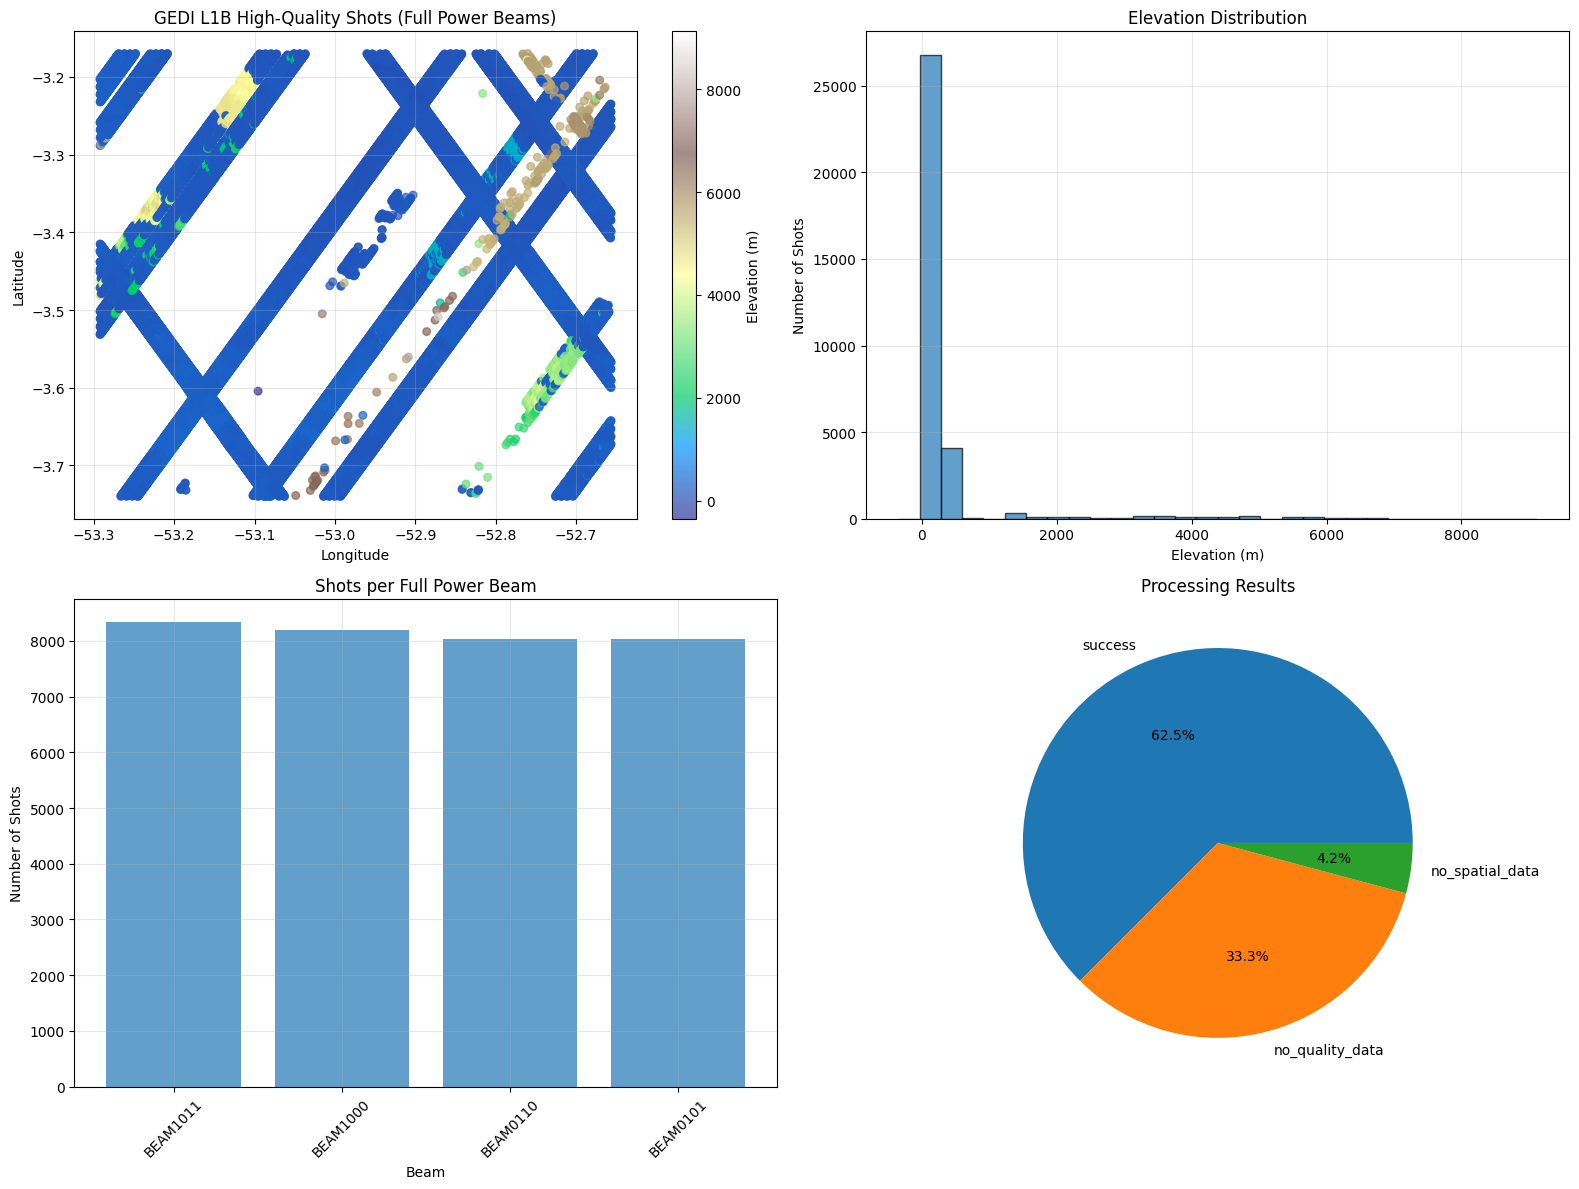


🗺️ Creating interactive map...

PROCESSING COMPLETE
✅ Data search completed
✅ Full Power beams processing only
✅ Automatic retry for quality data
✅ Demo optimization enabled (5th granule prioritized)
✅ File cleanup for unusable data
✅ Results exported

🔧 Next steps:
   - Modify aoi_bbox for your study area
   - Adjust quality filtering criteria if needed
   - Add waveform analysis functions
   - Process additional granules if needed

📁 Output files saved to: ./gedi_L1B_outputs/


In [2]:
# Authenticate with NASA Earthdata
# To download GEDI data, you need a NASA Earthdata account. If you don't have one, you can register for free.
# Run the authentication cell in the notebook, which will prompt you for your Earthdata credentials.


# Authenticate with NASA Earthdata
auth = earthaccess.login()

if auth.authenticated:
    print("✓ Successfully authenticated with NASA Earthdata!")
else:
    print("✗ Authentication failed. Please check your credentials.")

# Define your Area of Interest (AOI)
# Example: Pará and Northeast Pará and surrounding area near Double Springs 58.8982679169921823,-9.8411685263671949 : -46.0613679169921824,2.5911314736328070  ////-49.8971801984433938,-4.3451970939528763 : -45.6634012858677067,-0.5800425648302245
# Example 2: Medicilância: -53.2922282284325135,-3.7400166646731070, -52.6564362918175277,-3.1698933787883066
DEFAULT_AOI = [-53.2922282284325135,-3.7400166646731070, -52.6564362918175277,-3.1698933787883066]  # Default demo AOI
aoi_bbox = [-53.2922282284325135,-3.7400166646731070, -52.6564362918175277,-3.1698933787883066]  # [min_lon, min_lat, max_lon, max_lat]

# Check if user is using default AOI (for demo optimization)
is_default_aoi = (aoi_bbox == DEFAULT_AOI)

print(f"Area of Interest (Bounding Box): {aoi_bbox}")
print(f"Longitude range: {aoi_bbox[0]} to {aoi_bbox[2]}")
print(f"Latitude range: {aoi_bbox[1]} to {aoi_bbox[3]}")

if is_default_aoi:
    print(" Using default AOI - will prioritize 5th granule for demo efficiency")
else:
    print("Using custom AOI - will process granules in standard order")

# Define temporal range (2019-04-01-min value)
start_date = "2024-06-01" # Start of GEDI data aquisition
end_date = "2025-10-22" # Can update

print(f"Temporal range: {start_date} to {end_date}")

# Define Full Power beams only
FULL_POWER_BEAMS = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
print(f"Processing Full Power beams only: {FULL_POWER_BEAMS}")

# Search for GEDI L1B granules - FIXED VERSION
def search_gedi_l1b(bbox, start_date, end_date, max_results=2000):##40
    """
    Search for GEDI L1B granules - Fixed for newer earthaccess versions
    Increased max_results to have more options if files don't contain quality data

    Parameters:
    bbox: list of [min_lon, min_lat, max_lon, max_lat]
    """
    print(f"Searching for GEDI L1B data...")
    print(f"  Bounding box: {bbox}")
    print(f"  Date range: {start_date} to {end_date}")
    print(f"  Max results: {max_results}")

    # FIXED: Pass bounding box coordinates as separate arguments
    min_lon, min_lat, max_lon, max_lat = bbox

    try:
        results = earthaccess.search_data(
            short_name="GEDI01_B",
            version="002",
            bounding_box=(min_lon, min_lat, max_lon, max_lat),  # As tuple with 4 values
            temporal=(start_date, end_date),
            count=max_results
        )

        print(f"Found {len(results)} GEDI L1B granules")
        return results

    except Exception as e:
        print(f"Error in search: {str(e)}")
        print("Trying alternative bounding box format...")

        # Alternative format if the above doesn't work
        try:
            results = earthaccess.search_data(
                short_name="GEDI01_B",
                version="002",
                bounding_box=f"{min_lon},{min_lat},{max_lon},{max_lat}",  # As string
                temporal=(start_date, end_date),
                count=max_results
            )

            print(f"Found {len(results)} GEDI L1B granules")
            return results

        except Exception as e2:
            print(f"Second attempt failed: {str(e2)}")
            print("Trying without bounding box (will filter spatially later)...")

            # Last resort: search without spatial filter
            try:
                results = earthaccess.search_data(
                    short_name="GEDI01_B",
                    version="002",
                    temporal=(start_date, end_date),
                    count=max_results * 2  # Get more results to filter later
                )

                print(f"Found {len(results)} GEDI L1B granules (will filter spatially)")
                return results

            except Exception as e3:
                print(f"All search attempts failed: {str(e3)}")
                return []

# Extract and process data - Full Power beams only
def extract_gedi_l1b_data(file_path, aoi_bbox, full_power_beams_only=True):
    """Extract GEDI L1B data with spatial filtering - Full Power beams only"""
    extracted_data = {}

    print(f"\nOpening GEDI file: {os.path.basename(file_path)}")

    try:
        with h5py.File(file_path, 'r') as gedi_file:
            # Get all beam names
            all_beam_names = [key for key in gedi_file.keys() if key.startswith('BEAM')]

            # Filter to Full Power beams only
            if full_power_beams_only:
                beam_names = [beam for beam in all_beam_names if beam in FULL_POWER_BEAMS]
                print(f"Available beams: {all_beam_names}")
                print(f"Full Power beams found: {beam_names}")
            else:
                beam_names = all_beam_names
                print(f"Available beams: {beam_names}")

            if not beam_names:
                print("❌ No Full Power beams found in this file!")
                return {}

            for beam in beam_names:
                try:
                    print(f"\n  Processing {beam}...")

                    # Check if required datasets exist
                    required_datasets = [
                        f'{beam}/geolocation/latitude_bin0',
                        f'{beam}/geolocation/longitude_bin0',
                        f'{beam}/shot_number',
                        f'{beam}/geolocation/degrade',
                        f'{beam}/stale_return_flag',
                        f'{beam}/geolocation/elevation_bin0'
                    ]

                    missing_datasets = [ds for ds in required_datasets if ds not in gedi_file]
                    if missing_datasets:
                        print(f"    ⚠️ Missing datasets: {missing_datasets}")
                        continue

                    # Extract coordinate data
                    # The GEDI elevation_bin0 dataset refers to the height above the World Geodetic System 1984 (WGS84) reference ellipsoid, as interpolated from a pre-existing digital elevation model (DEM).
                    # This value provides a reference point for the ground elevation within a GEDI laser footprint.
                    lat = gedi_file[f'{beam}/geolocation/latitude_bin0'][:]
                    lon = gedi_file[f'{beam}/geolocation/longitude_bin0'][:]
                    shot_number = gedi_file[f'{beam}/shot_number'][:]
                    degrade_flag = gedi_file[f'{beam}/geolocation/degrade'][:]
                    stale_return_flag = gedi_file[f'{beam}/stale_return_flag'][:]
                    elev_bin0 = gedi_file[f'{beam}/geolocation/elevation_bin0'][:]

                    print(f"    Total shots in beam: {len(lat)}")

                    # Apply spatial filter
                    spatial_mask = (
                        (lon >= aoi_bbox[0]) & (lon <= aoi_bbox[2]) &
                        (lat >= aoi_bbox[1]) & (lat <= aoi_bbox[3])
                    )

                    spatial_shots = np.sum(spatial_mask)
                    print(f"    Shots in AOI: {spatial_shots}")

                    if spatial_shots > 0:
                        extracted_data[beam] = {
                            'latitude': lat[spatial_mask],
                            'longitude': lon[spatial_mask],
                            'shot_number': shot_number[spatial_mask],
                            'degrade_flag': degrade_flag[spatial_mask],
                            'stale_return_flag': stale_return_flag[spatial_mask],
                            'elevation_bin0': elev_bin0[spatial_mask]
                        }
                        print(f"    ✓ Extracted {spatial_shots} shots from {beam}")
                    else:
                        print(f"    ✗ No shots found in AOI for {beam}")

                except Exception as e:
                    print(f"    ❌ Error processing {beam}: {str(e)}")
                    continue

        return extracted_data

    except Exception as e:
        print(f"❌ Error opening file: {str(e)}")
        return {}

# Apply quality filtering with detailed reporting
def apply_quality_filters(gedi_data, verbose=True):
    """Apply standard GEDI quality filters with detailed reporting"""
    if verbose:
        print(f"\nApplying quality filters...")
        print("  Criteria: degrade_flag = 0, stale_return_flag = 0")

    filtered_data = {}
    total_before = 0
    total_after = 0

    for beam, data in gedi_data.items():
        if len(data['shot_number']) == 0:
            continue

        # Apply quality filters
        quality_mask = (
            (data['degrade_flag'] == 0) &
            (data['stale_return_flag'] == 0)
        )

        shots_before = len(data['shot_number'])
        shots_after = np.sum(quality_mask)
        retention_rate = (shots_after / shots_before * 100) if shots_before > 0 else 0

        total_before += shots_before
        total_after += shots_after

        if verbose:
            print(f"  {beam}: {shots_before} → {shots_after} shots ({retention_rate:.1f}% retained)")

        if shots_after > 0:
            filtered_data[beam] = {
                'latitude': data['latitude'][quality_mask],
                'longitude': data['longitude'][quality_mask],
                'shot_number': data['shot_number'][quality_mask],
                'elevation_bin0': data['elevation_bin0'][quality_mask],
                'degrade_flag': data['degrade_flag'][quality_mask],
                'stale_return_flag': data['stale_return_flag'][quality_mask]
            }

    overall_retention = (total_after / total_before * 100) if total_before > 0 else 0

    if verbose:
        print(f"\nOverall: {total_before} → {total_after} shots ({overall_retention:.1f}% retained)")

    return filtered_data, overall_retention, total_after

def delete_file_safely(file_path):
    """Safely delete a file with confirmation"""
    try:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"🗑️ Deleted file: {os.path.basename(file_path)}")
            return True
        else:
            print(f"⚠️ File not found for deletion: {file_path}")
            return False
    except Exception as e:
        print(f"❌ Error deleting file {file_path}: {str(e)}")
        return False

def process_gedi_granules_with_retry(gedi_granules, aoi_bbox, is_default_aoi=False, max_attempts=None):
    """
    Processa todos os granules encontrados, sem parar no primeiro com dados válidos.
    """
    download_dir = "./gedi_data"
    os.makedirs(download_dir, exist_ok=True)

    processed_files = []
    all_results = []

    # If you don't specify max_attempts, it processes all.
    if max_attempts is None:
        max_attempts = len(gedi_granules)

    for idx, granule in enumerate(gedi_granules[:max_attempts]):
        try:
            granule_id = granule['umm']['GranuleUR']
        except:
            granule_id = f"Granule_{idx+1}"

        print(f"\n{'='*80}")
        print(f"PROCESSANDO GRANULE {idx+1}/{len(gedi_granules)}: {granule_id}")
        print(f"{'='*80}")

        # Download
        try:
            downloaded_files = earthaccess.download([granule], local_path=download_dir)
            if not downloaded_files:
                print(f"❌ Falha no download de {granule_id}")
                continue
            sample_file = downloaded_files[0]
            file_size = os.path.getsize(sample_file) / 1e9
            print(f"✓ Baixado: {os.path.basename(sample_file)} ({file_size:.2f} GB)")
        except Exception as e:
            print(f"❌ Erro no download de {granule_id}: {str(e)}")
            continue

        # Processing
        gedi_data = extract_gedi_l1b_data(sample_file, aoi_bbox, full_power_beams_only=True)
        if not gedi_data:
            delete_file_safely(sample_file)
            processed_files.append({'granule_id': granule_id, 'status': 'no_spatial_data'})
            continue

        filtered_data, retention_rate, shots_after_qa = apply_quality_filters(gedi_data)

        total_shots_extracted = sum(len(v['shot_number']) for v in gedi_data.values())
        processed_files.append({
            'granule_id': granule_id,
            'file_name': os.path.basename(sample_file),
            'file_size_gb': file_size,
            'shots_extracted': total_shots_extracted,
            'shots_after_qa': shots_after_qa,
            'retention_rate': retention_rate,
            'status': 'success' if shots_after_qa > 0 else 'no_quality_data'
        })

        if shots_after_qa > 0:
            # Add the data to the complete set
            for beam, data in filtered_data.items():
                df = pd.DataFrame({
                    'granule_id': granule_id,
                    'beam': beam,
                    'shot_number': data['shot_number'],
                    'latitude': data['latitude'],
                    'longitude': data['longitude'],
                    'elevation_bin0': data['elevation_bin0']
                })
                all_results.append(df)

        else:
            delete_file_safely(sample_file)

    # Concatenates all results
    if all_results:
        result_df = pd.concat(all_results, ignore_index=True)
        print(f"\n🎉 Processamento completo: {len(result_df)} disparos de alta qualidade extraídos!")
        success = True
    else:
        print(f"\n❌ Nenhum granule teve dados de qualidade.")
        result_df = None
        success = False

    return success, result_df, processed_files, None

# Perform the search
print(f"\n🔍 Searching for GEDI L1B granules...")
gedi_granules = search_gedi_l1b(aoi_bbox, start_date, end_date, max_results=2000)##40

if gedi_granules:
    print(f"\n📋 Found granules:")
    for i, granule in enumerate(gedi_granules[:2]):  # Show first 5
        try:
            granule_id = granule['umm']['GranuleUR']
            demo_note = " (← DEMO PRIORITY)" if is_default_aoi and i == 1 else ""
            print(f"  {i+1}. {granule_id}{demo_note}")
        except:
            print(f"  {i+1}. Granule found (ID extraction failed)")

    if len(gedi_granules) > 2:
        print(f"  ... and {len(gedi_granules) - 2} more granules")

    # Process granules with automatic retry (and demo optimization if applicable)
    print(f"\n🚀 Starting processing with automatic retry...")
    success, result_df, processing_log, final_file = process_gedi_granules_with_retry(
    gedi_granules, aoi_bbox, is_default_aoi=is_default_aoi, max_attempts=len(gedi_granules)
)

    # Display processing summary
    print(f"\n{'='*80}")
    print("PROCESSING SUMMARY")
    print(f"{'='*80}")

    processing_df = pd.DataFrame(processing_log)
    if not processing_df.empty:
        print(f"\nFiles processed:")
        for _, row in processing_df.iterrows():
            status_icon = {
                'success': '✅',
                'no_spatial_data': '🚫',
                'no_quality_data': '❌',
                'processed': '📊'
            }.get(row['status'], '❓')

            print(f"  {status_icon} {row['file_name']} ({row['file_size_gb']:.2f} GB)")
            print(f"      Status: {row['status']}")
            print(f"      Shots extracted: {row['shots_extracted']}")
            print(f"      Shots after QA: {row['shots_after_qa']}")
            print(f"      Retention rate: {row['retention_rate']:.1f}%")

    if success and result_df is not None:
        print(f"\n🎉 FINAL RESULTS:")
        print(f"  ✅ Successfully processed granule with quality data")
        print(f"  📊 Total high-quality shots: {len(result_df)}")
        print(f"  🎯 Full Power beams processed: {result_df['beam'].nunique()}")

        # Display sample data
        print(f"\n📋 Sample of processed data:")
        print(result_df.head(10))

        print(f"\n📈 Data summary:")
        print(f"  Beams processed: {result_df['beam'].nunique()}")
        print(f"  Shots per beam: {result_df.groupby('beam').size().to_dict()}")
        print(f"  Elevation range: {result_df['elevation_bin0'].min():.1f} to {result_df['elevation_bin0'].max():.1f} m")
        print(f"  Latitude range: {result_df['latitude'].min():.6f} to {result_df['latitude'].max():.6f}")
        print(f"  Longitude range: {result_df['longitude'].min():.6f} to {result_df['longitude'].max():.6f}")

        # Export results
        output_dir = "./gedi_L1B_outputs"
        os.makedirs(output_dir, exist_ok=True)

        # Export main results
        csv_path = os.path.join(output_dir, "gedi_l1b_quality_filtered_full_power.csv")
        result_df.to_csv(csv_path, index=False)
        print(f"\n💾 Results exported to: {csv_path}")

        # Export processing log
        log_path = os.path.join(output_dir, "processing_log.csv")
        processing_df.to_csv(log_path, index=False)
        print(f"💾 Processing log exported to: {log_path}")

        # Create visualization
        print(f"\n📊 Creating visualizations...")
        plt.figure(figsize=(16, 10))

        # Create subplot layout
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Shot locations colored by elevation
        scatter = ax1.scatter(result_df['longitude'], result_df['latitude'],
                            c=result_df['elevation_bin0'], cmap='terrain', s=30, alpha=0.7)
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title('GEDI L1B High-Quality Shots (Full Power Beams)')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax1, label='Elevation (m)')

        # Plot 2: Elevation histogram
        ax2.hist(result_df['elevation_bin0'], bins=30, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Elevation (m)')
        ax2.set_ylabel('Number of Shots')
        ax2.set_title('Elevation Distribution')
        ax2.grid(True, alpha=0.3)

        # Plot 3: Shots per beam
        beam_counts = result_df['beam'].value_counts()
        ax3.bar(beam_counts.index, beam_counts.values, alpha=0.7)
        ax3.set_xlabel('Beam')
        ax3.set_ylabel('Number of Shots')
        ax3.set_title('Shots per Full Power Beam')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

        # Plot 4: Processing attempts
        status_counts = processing_df['status'].value_counts()
        ax4.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
        ax4.set_title('Processing Results')

        plt.tight_layout()
        plt.show()

        # Create interactive map
        print(f"\n🗺️ Creating interactive map...")
        center_lat = result_df['latitude'].mean()
        center_lon = result_df['longitude'].mean()

        m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

        # Add AOI rectangle
        folium.Rectangle(
            bounds=[[aoi_bbox[1], aoi_bbox[0]], [aoi_bbox[3], aoi_bbox[2]]],
            fill=False,
            color='red',
            weight=3,
            popup='Area of Interest'
        ).add_to(m)

        # Color map for different beams
        beam_colors = {'BEAM0101': 'red', 'BEAM0110': 'blue', 'BEAM1000': 'green', 'BEAM1011': 'orange'}

        # Add points colored by beam
        for _, row in result_df.iterrows():
            color = beam_colors.get(row['beam'], 'gray')
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=4,
                popup=f"Beam: {row['beam']}<br>Shot: {row['shot_number']}<br>Elevation: {row['elevation_bin0']:.1f}m",
                color=color,
                fillColor=color,
                fillOpacity=0.7
            ).add_to(m)

        # Add legend
        legend_html = '''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 150px; height: 90px;
                    background-color: white; border:2px solid grey; z-index:9999;
                    font-size:14px; padding: 10px">
        <p><b>Full Power Beams</b></p>
        <p><i class="fa fa-circle" style="color:red"></i> BEAM0101</p>
        <p><i class="fa fa-circle" style="color:blue"></i> BEAM0110</p>
        <p><i class="fa fa-circle" style="color:green"></i> BEAM1000</p>
        <p><i class="fa fa-circle" style="color:orange"></i> BEAM1011</p>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))

        # Display map
        m

    else:
        print(f"\n❌ PROCESSING FAILED:")
        print(f"  No granules contained quality data in the AOI")
        print(f"  Files attempted: {len(processing_log)}")
        print(f"\n💡 Suggestions:")
        print(f"    - Expand your AOI bounding box")
        print(f"    - Try a different time period")
        print(f"    - Check if your AOI is in a valid GEDI coverage area (±51.6° latitude)")

else:
    print("❌ No granules found. Try expanding your search criteria.")

print(f"\n{'='*80}")
print("PROCESSING COMPLETE")
print(f"{'='*80}")
print("✅ Data search completed")
print("✅ Full Power beams processing only")
print("✅ Automatic retry for quality data")
if is_default_aoi:
    print("✅ Demo optimization enabled (5th granule prioritized)")
print("✅ File cleanup for unusable data")
print("✅ Results exported")
print("\n🔧 Next steps:")
print("   - Modify aoi_bbox for your study area")
print("   - Adjust quality filtering criteria if needed")
print("   - Add waveform analysis functions")
print("   - Process additional granules if needed")
print("\n📁 Output files saved to: ./gedi_L1B_outputs/")

### Instructions

- Set or verify that the directory path is correct.

- Enter the latitude and longitude with five decimal places. To obtain the lat/long values, it is necessary to download and visualize the GEDI data in a GIS. This will allow you to determine whether the waveform falls within your sample area.


This code extracts the waveforms using latitude and longitude.

In [ ]:
####### Code runs by using coordinates ##

from time import sleep
import gc

# ================= Set up ===================
gedi_dir = "/content/gedi_data"
output_dir = "/content/waveform_plots"
os.makedirs(output_dir, exist_ok=True)

show_plots = True
pause_time = 1
tol = 1e-5  # tolerance in degrees (~1 m)

# 👉 Specific coordinates (set manually or use input)
latitude = float(input("Enter the desired latitude (5 decimal places): "))
longitude = float(input("Enter the desired longitude (5 decimal places): "))

# ===================================================

def process_waveform(beam, shot, f, file_name, output_dir):
    """Extracts and saves the 1 waveform graph"""
    try:
        if f"{beam}/shot_number" not in f:
            return False

        shot_numbers = f[f"{beam}/shot_number"][:]
        idx = np.where(shot_numbers == shot)[0]
        if len(idx) == 0:
            return False
        idx = idx[0]

        wf_full = f[f"{beam}/rxwaveform"][:]
        start = f[f"{beam}/rx_sample_start_index"][idx]
        count = f[f"{beam}/rx_sample_count"][idx]

        elev0 = f[f"{beam}/geolocation/elevation_bin0"][idx]
        elev_last = f[f"{beam}/geolocation/elevation_lastbin"][idx]
        lat = f[f"{beam}/geolocation/latitude_bin0"][idx]
        lon = f[f"{beam}/geolocation/longitude_bin0"][idx]

        waveform = wf_full[start:start+count]
        elevations = np.linspace(elev0, elev_last, len(waveform))

        # Point of maximum amplitude
        max_amp_idx = np.argmax(waveform)
        max_amp_elevation = elevations[max_amp_idx]
        max_amp_value = waveform[max_amp_idx]

        plt.figure(figsize=(8, 10))
        plt.plot(waveform, elevations, 'b', linewidth=2, label='Waveform')
        plt.scatter(max_amp_value, max_amp_elevation, color='red', s=50, label=f'Max Amp: {max_amp_elevation:.1f}m')
        plt.axhline(y=elev0, color='r', linestyle='--', label=f'Top: {elev0:.1f}m')
        plt.axhline(y=elev_last, color='g', linestyle='--', label=f'Bottom: {elev_last:.1f}m')
        plt.xlabel("Waveform Amplitude", fontsize=12)
        plt.ylabel("Elevation (m)", fontsize=12)
        plt.title(f"Shot {shot} - {beam}\nLat: {lat:.5f}, Lon: {lon:.5f}\nFile: {file_name}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"{beam}_{shot}.png")
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()

        print(f"💾 Saved {save_path}")
        return True

    except Exception as e:
        print(f"Error processing {beam}-{shot}: {e}")
        return False


def process_gedi_by_coord(gedi_dir, lat_alvo, lon_alvo, output_dir, tol=1e-5):
    """Search and extract waveforms for a specific latitude/longitude."""
    total_found = 0
    files = [os.path.join(gedi_dir, f) for f in os.listdir(gedi_dir) if f.endswith('.h5')]

    for file_path in files:
        try:
            with h5py.File(file_path, 'r') as f:
                available_beams = list(f.keys())
                print(f"🔍 Checking {os.path.basename(file_path)} ({len(available_beams)} beams)")

                for beam in available_beams:
                    if not (f"{beam}/geolocation/latitude_bin0" in f):
                        continue

                    lat_all = f[f"{beam}/geolocation/latitude_bin0"][:]
                    lon_all = f[f"{beam}/geolocation/longitude_bin0"][:]
                    shots_all = f[f"{beam}/shot_number"][:]

                    # Find coordinates within tolerance.
                    idx = np.where(
                        (np.abs(lat_all - lat_alvo) <= tol) &
                        (np.abs(lon_all - lon_alvo) <= tol)
                    )[0]

                    if len(idx) > 0:
                        shot = shots_all[idx[0]]
                        print(f"✅ Found in {os.path.basename(file_path)} — {beam}, shot {shot}")
                        ok = process_waveform(beam, shot, f,
                                              os.path.basename(file_path), output_dir)
                        if ok:
                            total_found += 1
                            if show_plots:
                                plt.show()
                                sleep(pause_time)

        except Exception as e:
            print(f"⚠️ Error reading {os.path.basename(file_path)}: {e}")

        gc.collect()

    print(f"\n🎯 Total number of waveforms extracted and saved: {total_found}")


# ================= Performance ===================
process_gedi_by_coord(
    gedi_dir=gedi_dir,
    lat_alvo=latitude,
    lon_alvo=longitude,
    output_dir=output_dir,
    tol=tol
)


### Instructions

- Set or verify that the directory path is correct.

- Enter the csv file with the selected waveforms. To obtain the lat/long values, it is necessary to download and visualize the GEDI data in a GIS. This will allow you to determine whether the waveform falls within your sample area.


This code extracts the waveforms a csv file.

In [ ]:
####### Code runs by using a csv file ##

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import gc

# ================= PARAMETERS ====================
gedi_dir = "/content/gedi_data"
csv_path = "/content/points/GEDI_L1B_Medicilandia_reduced.csv"
output_dir = "/content/waveform_plots"
os.makedirs(output_dir, exist_ok=True)

tol = 1e-5  # tolerance
# =================================================


def find_shot_by_coord_stream(f, beam, lat_alvo, lon_alvo, tol, chunk=20000):
    """
    Coordinate search without loading full arrays
    Reading latitude and longitude in smaller chunks
    """
    lat_ds = f[f"{beam}/geolocation/latitude_bin0"]
    lon_ds = f[f"{beam}/geolocation/longitude_bin0"]
    shot_ds = f[f"{beam}/shot_number"]

    total = lat_ds.shape[0]

    for i in range(0, total, chunk):
        end = min(i + chunk, total)
        lat = lat_ds[i:end]
        lon = lon_ds[i:end]

        idx = np.where(
            (np.abs(lat - lat_alvo) <= tol) &
            (np.abs(lon - lon_alvo) <= tol)
        )[0]

        if len(idx) > 0:
            return int(shot_ds[i + idx[0]])

    return None


def extract_waveform_minimal(f, beam, shot):
    """
    Extracts only the target shot waveform without loading the full rxwaveform dataset
    """
    # Finds the shot index
    shots = f[f"{beam}/shot_number"]

    # Search using blocks
    for i in range(0, shots.shape[0], 20000):
        end = min(i + 20000, shots.shape[0])
        block = shots[i:end]
        idx = np.where(block == shot)[0]
        if len(idx) > 0:
            idx = i + idx[0]
            break
    else:
        return None

    # Retrieves metadata.
    start = int(f[f"{beam}/rx_sample_start_index"][idx])
    count = int(f[f"{beam}/rx_sample_count"][idx])

    elev0 = float(f[f"{beam}/geolocation/elevation_bin0"][idx])
    elev_last = float(f[f"{beam}/geolocation/elevation_lastbin"][idx])

    # lê somente o intervalo necessário
    rx = f[f"{beam}/rxwaveform"]
    waveform = rx[start:start+count]

    elevations = np.linspace(elev0, elev_last, len(waveform))

    return waveform, elevations


def process(csv_path, gedi_dir, output_dir, tol):
    df = pd.read_csv(csv_path)

    # Open one figure per class
    figs = {}
    axes = {}

    files = [os.path.join(gedi_dir, x) for x in os.listdir(gedi_dir) if x.endswith(".h5")]

    for idx, row in df.iterrows():
        lat, lon, classe = row["latitude"], row["longitude"], row["classe"]
        print(f"\n🔍 Ponto {idx+1}: classe {classe} ({lat}, {lon})")

        if classe not in figs:
            figs[classe], axes[classe] = plt.subplots(figsize=(7, 10))

        ax = axes[classe]

        found = False

        for fp in files:
            with h5py.File(fp, "r") as f:
                for beam in f.keys():
                    if f"{beam}/geolocation/latitude_bin0" not in f:
                        continue

                    shot = find_shot_by_coord_stream(f, beam, lat, lon, tol)

                    if shot is None:
                        continue

                    print(f"✔ Encontrado: {os.path.basename(fp)} → {beam}, shot {shot}")

                    result = extract_waveform_minimal(f, beam, shot)
                    if result is None:
                        continue

                    wf, elev = result

                    # Add curve directly to the plot without keeping it in memory
                    ax.plot(wf, elev, linewidth=0.8)

                    found = True
                    break

            if found:
                break

        gc.collect()

    # Save all plots
    print("\n📊 Salvando imagens...")
    for classe, fig in figs.items():
        ax = axes[classe]
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("Elevação (m)")
        ax.set_title(f"Waveforms da Classe {classe}")
        ax.grid(alpha=0.3)

        fig.tight_layout()
        save_path = os.path.join(output_dir, f"classe_{classe}.png")
        fig.savefig(save_path, dpi=200)
        plt.close(fig)
        print(f"  💾 {save_path}")

    print("\n🏁 Finalizado com uso mínimo de memória!\n")


# execute
process(csv_path, gedi_dir, output_dir, tol)

### Instructions

- Set or verify that the directory path is correct.

- Enter the csv file with the selected waveforms. To obtain the lat/long values, it is necessary to download and visualize the GEDI data in a GIS. This will allow you to determine whether the waveform falls within your sample area.


This code extracts the waveforms a csv file, creating a mean and std graph .

In [ ]:
## Code runs by using csv, creating a mean and std graph ##

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import gc

# ================= PARAMETERS ====================
#.csv needs latitude, longitude, class
gedi_dir = "/content/gedi_data"
csv_path = "/content/points/GEDI_L1B_Medicilandia_samples.csv"
output_dir = "/content/waveform_plots"
os.makedirs(output_dir, exist_ok=True)

tol = 1e-5
N_GRID = 400  # Common elevation grid
# =================================================


def find_shot_by_coord_stream(f, beam, lat_alvo, lon_alvo, tol, chunk=20000):
    lat = f[f"{beam}/geolocation/latitude_bin0"]
    lon = f[f"{beam}/geolocation/longitude_bin0"]
    shots = f[f"{beam}/shot_number"]

    total = len(lat)

    for i in range(0, total, chunk):
        end = min(i + chunk, total)
        block_lat = lat[i:end]
        block_lon = lon[i:end]

        idx = np.where(
            (np.abs(block_lat - lat_alvo) <= tol) &
            (np.abs(block_lon - lon_alvo) <= tol)
        )[0]

        if len(idx) > 0:
            return int(shots[i + idx[0]])

    return None


def extract_waveform_minimal(f, beam, shot):
    shots = f[f"{beam}/shot_number"]

    # Sequential search
    for i in range(0, shots.shape[0], 20000):
        end = min(i + 20000, shots.shape[0])
        block = shots[i:end]
        idx = np.where(block == shot)[0]
        if len(idx):
            idx = i + idx[0]
            break
    else:
        return None

    start = int(f[f"{beam}/rx_sample_start_index"][idx])
    count = int(f[f"{beam}/rx_sample_count"][idx])

    elev0 = float(f[f"{beam}/geolocation/elevation_bin0"][idx])
    elev_last = float(f[f"{beam}/geolocation/elevation_lastbin"][idx])

    waveform = f[f"{beam}/rxwaveform"][start:start + count]
    elevations = np.linspace(elev0, elev_last, len(waveform))

    return waveform, elevations


def process(csv_path, gedi_dir, output_dir, tol):
    df = pd.read_csv(csv_path)

    class_waveforms = {}   # Stores resampled curves
    class_elev_grids = {}  # Uniform Y-axis

    files = [os.path.join(gedi_dir, f) for f in os.listdir(gedi_dir) if f.endswith(".h5")]

    for idx, row in df.iterrows():
        lat, lon, classe = row["latitude"], row["longitude"], row["classe"]
        print(f"\n🔍 Procurando: classe {classe}, ponto {idx+1}")

        if classe not in class_waveforms:
            class_waveforms[classe] = []
            class_elev_grids[classe] = None

        found = False

        for fp in files:
            with h5py.File(fp, "r") as f:

                for beam in f.keys():
                    if f"{beam}/geolocation/latitude_bin0" not in f:
                        continue

                    shot = find_shot_by_coord_stream(f, beam, lat, lon, tol)
                    if not shot:
                        continue

                    print(f"✔ Encontrado em {fp} → {beam}, shot {shot}")

                    result = extract_waveform_minimal(f, beam, shot)
                    if not result:
                        continue

                    wf, elev = result

                    # Creates a fixed grid similar to the wavelength in R
                    if class_elev_grids[classe] is None:
                        class_elev_grids[classe] = np.linspace(
                            max(elev), min(elev), N_GRID
                        )

                    elev_grid = class_elev_grids[classe]

                    wf_interp = np.interp(elev_grid, elev[::-1], wf[::-1])
                    class_waveforms[classe].append(wf_interp)

                    found = True
                    break

            if found:
                break

        gc.collect()


    # ====================================================
    #            FINAL: PLOT MEAN + DEVIATION
    # ====================================================
    for classe in class_waveforms.keys():

        wave_list = class_waveforms[classe]
        elev_grid = class_elev_grids[classe]

        if len(wave_list) == 0:
            continue

        n_waveforms = len(wave_list)   # <<< Number of waveforms

        arr = np.vstack(wave_list)
        mean_curve = arr.mean(axis=0)
        std_curve = arr.std(axis=0)

        plt.figure(figsize=(10, 12))

        # ribbon (deviation area)
        plt.fill_betweenx(
            elev_grid,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color="cornflowerblue",
            alpha=0.25,
            label="Standard Deviation"
        )

        # mean line
        plt.plot(mean_curve, elev_grid, color="blue", linewidth=2.5, label="Mean")

        # keep original direction
        plt.xlabel("Waveform Amplitude", fontsize=12,fontweight="bold")
        plt.ylabel("Elevation (m)", fontsize=12, fontweight="bold")
        plt.title(f"Waveform – {classe}", fontsize=14,fontweight="bold")
        plt.grid(alpha=0.3)
        plt.legend()

        # Fixe vertical scale between -20 and 80 m
        plt.ylim(-20, 60)
        plt.xlim(0, 700)

        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        # Insert text with number of waveforms
        plt.text(
            0.02, 0.95,
            f"Number of Waveforms: {n_waveforms}",
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )
        # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        plt.tight_layout()
        save_path = os.path.join(output_dir, f"{classe}_media_desvio.png")
        plt.savefig(save_path, dpi=250)
        plt.close()

        print(f"💾 Salvo: {save_path}")


# execute
process(csv_path, gedi_dir, output_dir, tol)


### Instructions

- Set or verify that the directory path is correct.

- Enter the csv file with the selected waveforms. To obtain the lat/long values, it is necessary to download and visualize the GEDI data in a GIS. This will allow you to determine whether the waveform falls within your sample area.


This code extracts the waveforms a csv file, creating a mean and std graph with robust outlier removal.

In [ ]:
# ======================== ENHANCED: Comparison of waveforms and robust outlier removal ========================
# keep the structure, just adding better methods to compare waveforms.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import gc

# ================= PARAMETERS ====================
gedi_dir = "/content/gedi_data"
csv_path = "/content/points/culturas_perenes_amostras.csv"
output_dir = "/content/waveform_plots"
os.makedirs(output_dir, exist_ok=True)

tol = 1e-5
N_GRID = 400
# =================================================


def find_shot_by_coord_stream(f, beam, lat_alvo, lon_alvo, tol, chunk=20000):
    lat = f[f"{beam}/geolocation/latitude_bin0"]
    lon = f[f"{beam}/geolocation/longitude_bin0"]
    shots = f[f"{beam}/shot_number"]

    total = len(lat)
    for i in range(0, total, chunk):
        end = min(i + chunk, total)
        block_lat = lat[i:end]
        block_lon = lon[i:end]

        idx = np.where(
            (np.abs(block_lat - lat_alvo) <= tol) &
            (np.abs(block_lon - lon_alvo) <= tol)
        )[0]

        if len(idx) > 0:
            return int(shots[i + idx[0]])

    return None


def extract_waveform_minimal(f, beam, shot):
    shots = f[f"{beam}/shot_number"]

    for i in range(0, shots.shape[0], 20000):
        end = min(i + 20000, shots.shape[0])
        block = shots[i:end]
        idx = np.where(block == shot)[0]
        if len(idx):
            idx = i + idx[0]
            break
    else:
        return None

    start = int(f[f"{beam}/rx_sample_start_index"][idx])
    count = int(f[f"{beam}/rx_sample_count"][idx])

    elev0 = float(f[f"{beam}/geolocation/elevation_bin0"][idx])
    elev_last = float(f[f"{beam}/geolocation/elevation_lastbin"][idx])

    waveform = f[f"{beam}/rxwaveform"][start:start + count]
    elevations = np.linspace(elev0, elev_last, len(waveform))

    return waveform, elevations


def rms_distance(a, b):
    """Distância RMS entre dois vetores."""
    return np.sqrt(np.mean((a - b) ** 2))


def process(csv_path, gedi_dir, output_dir, tol):
    df = pd.read_csv(csv_path)

    class_waveforms = {}
    class_elev_grids = {}

    files = [os.path.join(gedi_dir, f) for f in os.listdir(gedi_dir) if f.endswith(".h5")]

    for idx, row in df.iterrows():
        lat, lon, classe = row["latitude"], row["longitude"], row["classe"]
        print(f"\n🔍 Procurando: classe {classe}, ponto {idx+1}")

        if classe not in class_waveforms:
            class_waveforms[classe] = []
            class_elev_grids[classe] = None

        found = False

        for fp in files:
            with h5py.File(fp, "r") as f:

                for beam in f.keys():
                    if f"{beam}/geolocation/latitude_bin0" not in f:
                        continue

                    shot = find_shot_by_coord_stream(f, beam, lat, lon, tol)
                    if not shot:
                        continue

                    print(f"✔ Encontrado em {fp} → {beam}, shot {shot}")

                    result = extract_waveform_minimal(f, beam, shot)
                    if not result:
                        continue

                    wf, elev = result

                    if class_elev_grids[classe] is None:
                        class_elev_grids[classe] = np.linspace(max(elev), min(elev), N_GRID)

                    elev_grid = class_elev_grids[classe]
                    wf_interp = np.interp(elev_grid, elev[::-1], wf[::-1])
                    class_waveforms[classe].append(wf_interp)

                    found = True
                    break

            if found:
                break

        gc.collect()

    # ====================================================
    #            COMPARISON AND REMOTION OF OUTLIERS
    # ====================================================
    for classe in class_waveforms.keys():

        wave_list = class_waveforms[classe]
        elev_grid = class_elev_grids[classe]

        if len(wave_list) == 0:
            continue

        arr = np.vstack(wave_list)

        prelim_mean = arr.mean(axis=0)

        distances = np.array([rms_distance(w, prelim_mean) for w in arr])

        mean_dist = distances.mean()
        std_dist = distances.std()

        threshold = mean_dist + 3 * std_dist

        mask = distances <= threshold
        arr_clean = arr[mask]

        removed = np.sum(~mask)
        kept = np.sum(mask)

        print(f"🧹 Classe {classe}: removidos {removed} outliers, mantidos {kept}")

        arr = arr_clean

        mean_curve = arr.mean(axis=0)
        std_curve = arr.std(axis=0)

        n_waveforms = arr.shape[0]

        # =====================================================
        #                     FINAL PLOT
        # =====================================================
        plt.figure(figsize=(10, 12))

        plt.fill_betweenx(
            elev_grid,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color="cornflowerblue",
            alpha=0.25,
            label="Standard Deviation"
        )

        plt.plot(mean_curve, elev_grid, color="blue", linewidth=2.5, label="Mean")

        # =============== INCREASE SOURCE SIZE ===============
        plt.xlabel("Waveform Amplitude", fontsize=16, fontweight="bold")
        plt.ylabel("Elevation (m)", fontsize=16, fontweight="bold")
        plt.title(f"Waveform – {classe}", fontsize=20, fontweight="bold")
        plt.legend(fontsize=14)
        # ==============================================================

        plt.grid(alpha=0.3)

        #plt.ylim(60, 160) - transamazonica
        #plt.xlim(0, 1000)

        plt.ylim(-20, 60)
        plt.xlim(0, 700)

        plt.text(
            0.02, 0.95,
            f"Waveforms used: {n_waveforms}",
            transform=plt.gca().transAxes,
            fontsize=14,   # increased size
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )

        plt.tight_layout()
        save_path = os.path.join(output_dir, f"{classe}_comparacao_outliers.png")
        plt.savefig(save_path, dpi=250)
        plt.close()

        print(f"💾 Salvo: {save_path}")


# execute
process(csv_path, gedi_dir, output_dir, tol)



In [ ]:
# ======================== NORMALIZATION + PLOT WITH WAVEFORMS NORMALIZED ========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import gc
from scipy.signal import find_peaks   # <-- ADDED

# ================= PARAMETERS ====================
gedi_dir = "/content/gedi_data"
csv_path = "/content/points/Samples_cocoa_medicilandia.csv"
output_dir = "/content/waveform_plots"
os.makedirs(output_dir, exist_ok=True)

tol = 1e-5
N_GRID = 400
NORMALIZATION_METHOD = "minmax"
ELEVATION_NORM_METHOD = "minmax"
PEAK_RATIO = 0.7     # <-- ONLY PEAKS ABOVE 60%
# =================================================


# =================================================
#       UNIVERSAL NORMALIZATION FUNCTION
# =================================================
def normalize_waveform(wf, method="minmax"):
    wf = np.array(wf, dtype=float)

    if method == "minmax":
        wmin, wmax = wf.min(), wf.max()
        if np.isclose(wmax, wmin):
            return np.zeros_like(wf)
        return (wf - wmin) / (wmax - wmin)

    elif method == "l2":
        norm = np.linalg.norm(wf)
        if norm == 0:
            return np.zeros_like(wf)
        return wf / norm

    elif method == "zscore":
        mean = wf.mean()
        std = wf.std()
        if std < 1e-6:
            return np.zeros_like(wf)
        return (wf - mean) / std

    else:
        raise ValueError("Método inválido: use 'minmax', 'l2' ou 'zscore'")

# =================================================
#               AXE Y NOMRMALIZATION
# =================================================
def normalize_axis(values, method="minmax"):
    values = np.array(values, dtype=float)

    if method == "minmax":
        vmin, vmax = values.min(), values.max()
        if np.isclose(vmax, vmin):
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    elif method == "zscore":
        mean = values.mean()
        std = values.std()
        if std < 1e-6:
            return np.zeros_like(values)
        return (values - mean) / std

    elif method == "l2":
        norm = np.linalg.norm(values)
        if norm < 1e-6:
            return np.zeros_like(values)
        return values / norm

    else:
        raise ValueError("Método inválido para eixo Y")


# =================================================
# NEW FUNCTION: COUNT OF PEAKS GREATER THAN 60%
# =================================================
def count_large_peaks_ratio(wave, ratio=0.6, distance=5):
    """
    Conta picos cuja altura seja maior que (ratio * pico máximo da waveform).
    ratio: entre 0 e 1 (ex: 0.6 = picos acima de 60% do valor máximo)
    """
    max_val = wave.max()
    height_min = max_val * ratio
    peaks, props = find_peaks(wave, height=height_min, distance=distance)
    return len(peaks), peaks, props["peak_heights"]


# =================================================
#                 EXISTING FUNCTION
# =================================================
def find_shot_by_coord_stream(f, beam, lat_alvo, lon_alvo, tol, chunk=20000):
    lat = f[f"{beam}/geolocation/latitude_bin0"]
    lon = f[f"{beam}/geolocation/longitude_bin0"]
    shots = f[f"{beam}/shot_number"]

    total = len(lat)
    for i in range(0, total, chunk):
        end = min(i + chunk, total)
        block_lat = lat[i:end]
        block_lon = lon[i:end]

        idx = np.where(
            (np.abs(block_lat - lat_alvo) <= tol) &
            (np.abs(block_lon - lon_alvo) <= tol)
        )[0]

        if len(idx) > 0:
            return int(shots[i + idx[0]])

    return None


def extract_waveform_minimal(f, beam, shot):
    shots = f[f"{beam}/shot_number"]

    for i in range(0, shots.shape[0], 20000):
        end = min(i + 20000, shots.shape[0])
        block = shots[i:end]
        idx = np.where(block == shot)[0]
        if len(idx):
            idx = i + idx[0]
            break
    else:
        return None

    start = int(f[f"{beam}/rx_sample_start_index"][idx])
    count = int(f[f"{beam}/rx_sample_count"][idx])

    elev0 = float(f[f"{beam}/geolocation/elevation_bin0"][idx])
    elev_last = float(f[f"{beam}/geolocation/elevation_lastbin"][idx])

    waveform = f[f"{beam}/rxwaveform"][start:start + count]
    elevations = np.linspace(elev0, elev_last, len(waveform))

    return waveform, elevations


def rms_distance(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


# =================================================
#       EXECUTION
# =================================================
def process(csv_path, gedi_dir, output_dir, tol):
    df = pd.read_csv(csv_path)

    class_waveforms = {}
    class_elev_grids = {}

    files = [os.path.join(gedi_dir, f) for f in os.listdir(gedi_dir) if f.endswith(".h5")]

    for idx, row in df.iterrows():
        lat, lon, classe = row["latitude"], row["longitude"], row["classe"]
        print(f"\n🔍 Procurando: classe {classe}, ponto {idx+1}")

        if classe not in class_waveforms:
            class_waveforms[classe] = []
            class_elev_grids[classe] = None

        found = False

        for fp in files:
            with h5py.File(fp, "r") as f:

                for beam in f.keys():
                    if f"{beam}/geolocation/latitude_bin0" not in f:
                        continue

                    shot = find_shot_by_coord_stream(f, beam, lat, lon, tol)
                    if not shot:
                        continue

                    print(f"✔ Encontrado em {fp} → {beam}, shot {shot}")

                    result = extract_waveform_minimal(f, beam, shot)
                    if not result:
                        continue

                    wf, elev = result

                    if class_elev_grids[classe] is None:
                        class_elev_grids[classe] = np.linspace(max(elev), min(elev), N_GRID)

                    elev_grid = class_elev_grids[classe]

                    wf_interp = np.interp(elev_grid, elev[::-1], wf[::-1])
                    wf_interp = normalize_waveform(wf_interp, method=NORMALIZATION_METHOD)

                    class_waveforms[classe].append(wf_interp)
                    found = True
                    break

            if found:
                break

        gc.collect()

    # ====================================================
    #            COMPARISON AND REMOVAL OUTLIERS
    # ====================================================
    for classe in class_waveforms.keys():

        wave_list = class_waveforms[classe]
        elev_grid = class_elev_grids[classe]

        if len(wave_list) == 0:
            print(f"⚠ Classe {classe} não teve nenhuma waveform encontrada.")
            continue

        arr = np.vstack(wave_list)

        prelim_mean = arr.mean(axis=0)
        distances = np.array([rms_distance(w, prelim_mean) for w in arr])

        mean_dist = distances.mean()
        std_dist = distances.std()
        threshold = mean_dist + 3 * std_dist

        mask = distances <= threshold
        arr_clean = arr[mask]

        removed = np.sum(~mask)
        kept = np.sum(mask)

        print(f"🧹 Classe {classe}: removidos {removed} outliers, mantidos {kept}")

        arr = arr_clean

        mean_curve = arr.mean(axis=0)
        std_curve = arr.std(axis=0)

        # =====================================================
        #         CONTING OF LARGE PEAKS(>70%)
        # =====================================================
        num_large_peaks, peaks_large, heights_large = count_large_peaks_ratio(
            mean_curve, ratio=PEAK_RATIO
        )


        # =====================================================
        #                     FINAL PLOT
        # =====================================================
        elev_norm = normalize_axis(elev_grid, method=ELEVATION_NORM_METHOD)

        plt.figure(figsize=(10, 12))

        plt.fill_betweenx(
            elev_norm,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color="cornflowerblue",
            alpha=0.25,
            label="Standard Deviation"
        )

        plt.plot(mean_curve, elev_norm, color="blue", linewidth=2.5, label="Mean")

        #  Marks the large peaks in red
        plt.scatter(mean_curve[peaks_large], elev_norm[peaks_large],
                    color="red", s=60, label="Peaks >70%")

        plt.xlabel("Normalized Waveform", fontsize=18, fontweight="bold")
        plt.ylabel("Normalized Elevation", fontsize=18, fontweight="bold")

        plt.title(
            f"Waveform – {classe}\n"
            f"WF norm: {NORMALIZATION_METHOD} | Elev norm: {ELEVATION_NORM_METHOD}",
            fontsize=20, fontweight="bold"
        )

        plt.legend(fontsize=14)

        # Text with count
        plt.text(
            0.02, 0.02,
            f"Waveforms: {kept}\n"
            f"Peaks >70%: {num_large_peaks}",
            transform=plt.gca().transAxes,
            fontsize=16,
            bbox=dict(facecolor='white', alpha=0.6)
        )

        plt.tick_params(axis='both', labelsize=18)

        plt.grid(alpha=0.3)
        plt.tight_layout()

        # ===== SAVE THE PLOT =====
        save_path = os.path.join(output_dir, f"{classe}_comparacao_outliers_norm.png")
        plt.savefig(save_path, dpi=250)
        plt.close()

        print(f"💾 Salvo: {save_path}")


# execute
process(csv_path, gedi_dir, output_dir, tol)




